In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('clean_data.csv')
df.head()

,Date_Object,Total_Power_Generation
0,2019-02-01,112.22261
1,2019-03-01,107.36345
2,2019-04-01,91.67904
3,2019-07-01,107.53155
4,2019-08-01,105.01283


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date_Object             57 non-null     object 
 1   Total_Power_Generation  57 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.0+ KB


In [4]:
df['Date_Object'] = pd.to_datetime(df['Date_Object'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date_Object             57 non-null     datetime64[ns]
 1   Total_Power_Generation  57 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 KB


In [5]:
df.head()

,Date_Object,Total_Power_Generation
0,2019-02-01,112.22261
1,2019-03-01,107.36345
2,2019-04-01,91.67904
3,2019-07-01,107.53155
4,2019-08-01,105.01283


In [6]:
df.set_index('Date_Object', inplace=True)
df.head()

,Total_Power_Generation
Date_Object,
2019-02-01,112.22261
2019-03-01,107.36345
2019-04-01,91.67904
2019-07-01,107.53155
2019-08-01,105.01283


<Axes: xlabel='Date_Object', ylabel='Total_Power_Generation'>

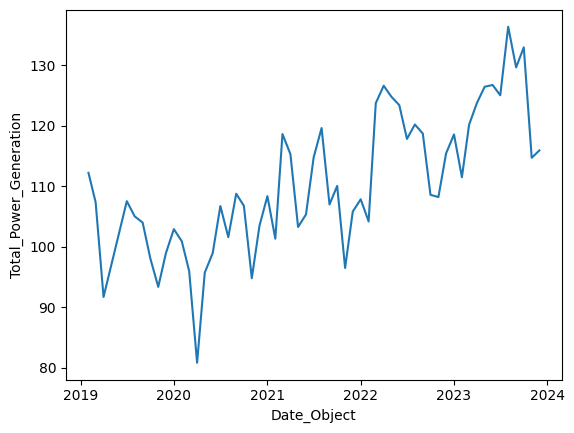

In [7]:
sns.lineplot(data=df,x=df.index,y=df.Total_Power_Generation)

Looking at the pattern, we a seasonal data pattern.
There are 4 types of pattern: 
1. Trend : Increasing or decreasing by time
2. Seasonal : Eg. Icecream sales increase during april, may months and decrease during rest of the year.
3. Cyclic : The trend continues for sometime and then it goes away. It has no fixed time, when it would come back. Eg. Covid cases spiked in 2019 and reduced in consequent years
4. Irregular : Very irregular data, avoided for analysis.

The above data is non stationery, coz the mean and variance changes.

------->We will start with rolling statistics

In [8]:
df['rollmean'] = df.Total_Power_Generation.rolling(window=12).mean()
df['rollstd'] = df.Total_Power_Generation.rolling(window=12).std()

<Axes: xlabel='Date_Object', ylabel='Total_Power_Generation'>

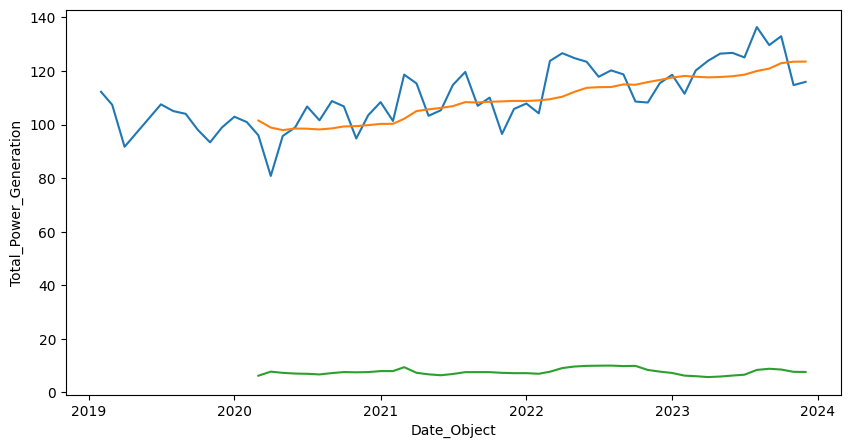

In [9]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df,x=df.index,y=df.Total_Power_Generation)
sns.lineplot(data=df,x=df.index,y=df.rollmean)
sns.lineplot(data=df,x=df.index,y=df.rollstd)


In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
adfTest = adfuller(df['Total_Power_Generation'],autolag = 'AIC')
adfTest

(-2.833271123868754,
 0.05367613976602283,
 0,
 56,
 {'1%': -3.552928203580539,
  '5%': -2.9147306250000002,
  '10%': -2.595137155612245},
 315.80950929459436)

In [12]:
stats = pd.Series(adfTest[0:4], index = ['Test Statistic', 'p-value', '#lags used', 'number of observations used'])
stats

Test Statistic                 -2.833271
p-value                         0.053676
#lags used                      0.000000
number of observations used    56.000000
dtype: float64

In [13]:
for key, values in adfTest[4].items():
    print('criticality', key,': ',values)

criticality 1% :  -3.552928203580539
criticality 5% :  -2.9147306250000002
criticality 10% :  -2.595137155612245


Test Statistic < Criticality but here, one value is not

We have to make data stationery, so there are many ways: Time shift, log, Square Root, Cube....
We will start with time shift

1. In time shift, we shift the data by one column, in log, we find the the log of the data, in square root, we find square root of data.

In [14]:
def test_stationarity(dataFrame, var):
    dataFrame['rollmean'] = dataFrame[var].rolling(window=12).mean()
    dataFrame['rollstd'] = dataFrame[var].rolling(window=12).std()

    from statsmodels.tsa.stattools import adfuller
    adfTest = adfuller(dataFrame['Total_Power_Generation'],autolag = 'AIC')
    stats = pd.Series(adfTest[0:4], index = ['Test Statistic', 'p-value', '#lags used', 'number of observations used'])
    print(stats)
    for key, values in adfTest[4].items():
        print('criticality', key,': ',values)
    
    sns.lineplot(data=dataFrame,x=dataFrame.index,y=var)
    sns.lineplot(data=dataFrame,x=dataFrame.index,y='rollmean')
    sns.lineplot(data=dataFrame,x=dataFrame.index,y='rollstd')

A function for testing any data for the statistic values.
Orange curve: mean curve
Green curve: standard deviation curve

Test Statistic                 -2.833271
p-value                         0.053676
#lags used                      0.000000
number of observations used    56.000000
dtype: float64
criticality 1% :  -3.552928203580539
criticality 5% :  -2.9147306250000002
criticality 10% :  -2.595137155612245


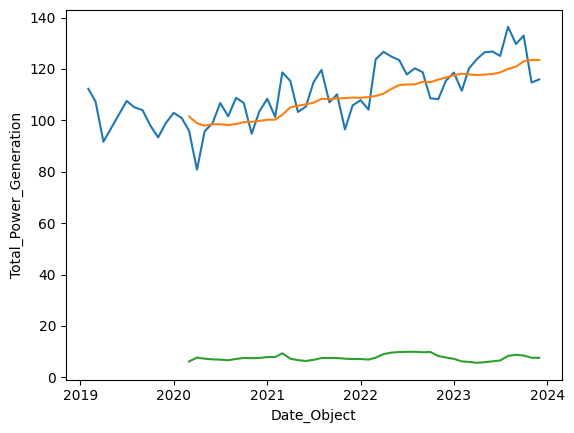

In [15]:
test_stationarity(df, 'Total_Power_Generation')

In [16]:
df.head()

,Total_Power_Generation,rollmean,rollstd
Date_Object,,,
2019-02-01,112.22261,NaN,NaN
2019-03-01,107.36345,NaN,NaN
2019-04-01,91.67904,NaN,NaN
2019-07-01,107.53155,NaN,NaN
2019-08-01,105.01283,NaN,NaN


In [17]:
air_df = df[['Total_Power_Generation']]
air_df.head()

,Total_Power_Generation
Date_Object,
2019-02-01,112.22261
2019-03-01,107.36345
2019-04-01,91.67904
2019-07-01,107.53155
2019-08-01,105.01283


Starting with time shift

In [18]:
air_df['shift'] = air_df.Total_Power_Generation.shift()     #to shift by one month, keep empty, to shift by more months, add value
air_df['shiftDiff'] = air_df['Total_Power_Generation'] - air_df['shift'] 
air_df.head()

C:\Users\adity\AppData\Local\Temp\ipykernel_13944\1865876682.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_df['shift'] = air_df.Total_Power_Generation.shift()     #to shift by one month, keep empty, to shift by more months, add value


,Total_Power_Generation,shift,shiftDiff
Date_Object,,,
2019-02-01,112.22261,NaN,NaN
2019-03-01,107.36345,112.22261,-4.85916
2019-04-01,91.67904,107.36345,-15.68441
2019-07-01,107.53155,91.67904,15.85251
2019-08-01,105.01283,107.53155,-2.51872


We will check stationarity of the data.

C:\Users\adity\AppData\Local\Temp\ipykernel_13944\2896759308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollmean'] = dataFrame[var].rolling(window=12).mean()
C:\Users\adity\AppData\Local\Temp\ipykernel_13944\2896759308.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollstd'] = dataFrame[var].rolling(window=12).std()


Test Statistic                 -2.803266
p-value                         0.057809
#lags used                      0.000000
number of observations used    55.000000
dtype: float64
criticality 1% :  -3.5552728880540942
criticality 5% :  -2.9157312396694217
criticality 10% :  -2.5956695041322315


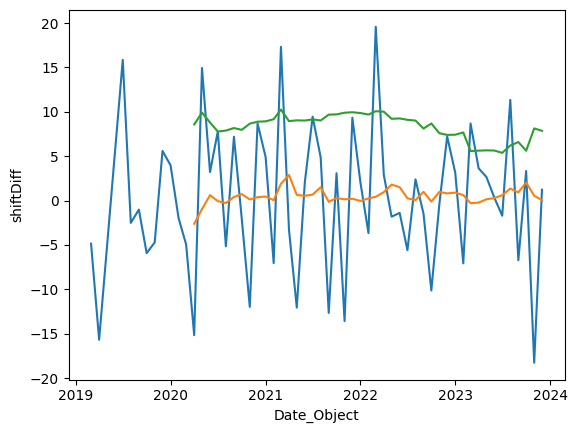

In [19]:
test_stationarity(air_df.dropna(),'shiftDiff')

The data is much stationery right now compared to earlier.

In [20]:
log_df = df[['Total_Power_Generation']]
log_df['log'] = np.log(log_df['Total_Power_Generation'])
log_df.head()

C:\Users\adity\AppData\Local\Temp\ipykernel_13944\854222627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df['log'] = np.log(log_df['Total_Power_Generation'])


,Total_Power_Generation,log
Date_Object,,
2019-02-01,112.22261,4.720484
2019-03-01,107.36345,4.676220
2019-04-01,91.67904,4.518294
2019-07-01,107.53155,4.677784
2019-08-01,105.01283,4.654083


Test Statistic                 -2.833271
p-value                         0.053676
#lags used                      0.000000
number of observations used    56.000000
dtype: float64
criticality 1% :  -3.552928203580539
criticality 5% :  -2.9147306250000002
criticality 10% :  -2.595137155612245


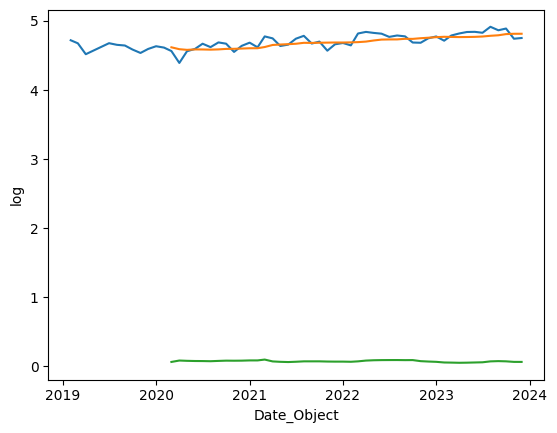

In [21]:
test_stationarity(log_df,'log')

In [22]:
sqrt_df = df[['Total_Power_Generation']]
sqrt_df['sqrt'] = np.sqrt(df['Total_Power_Generation'])
sqrt_df.head()

C:\Users\adity\AppData\Local\Temp\ipykernel_13944\4031663183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sqrt_df['sqrt'] = np.sqrt(df['Total_Power_Generation'])


,Total_Power_Generation,sqrt
Date_Object,,
2019-02-01,112.22261,10.593517
2019-03-01,107.36345,10.361634
2019-04-01,91.67904,9.574917
2019-07-01,107.53155,10.369742
2019-08-01,105.01283,10.247577


Test Statistic                 -2.833271
p-value                         0.053676
#lags used                      0.000000
number of observations used    56.000000
dtype: float64
criticality 1% :  -3.552928203580539
criticality 5% :  -2.9147306250000002
criticality 10% :  -2.595137155612245


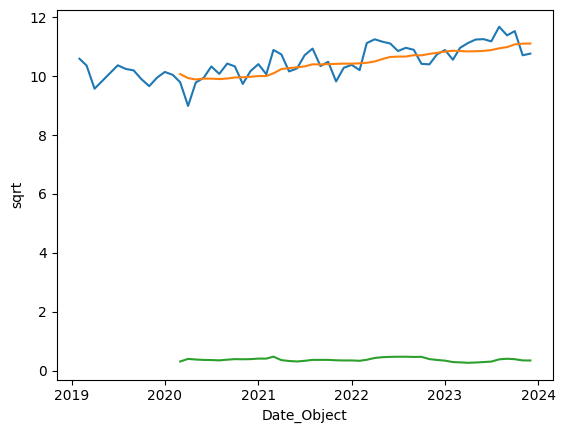

In [23]:
test_stationarity(sqrt_df,'sqrt')

STATIONARITY WITH CUBE ROOT

In [24]:
cbrt_df = df[['Total_Power_Generation']]
cbrt_df['cbrt'] = np.cbrt(cbrt_df['Total_Power_Generation'])
cbrt_df.head()

C:\Users\adity\AppData\Local\Temp\ipykernel_13944\3173789068.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbrt_df['cbrt'] = np.cbrt(cbrt_df['Total_Power_Generation'])


,Total_Power_Generation,cbrt
Date_Object,,
2019-02-01,112.22261,4.823476
2019-03-01,107.36345,4.752829
2019-04-01,91.67904,4.509102
2019-07-01,107.53155,4.755308
2019-08-01,105.01283,4.717886


Test Statistic                 -2.833271
p-value                         0.053676
#lags used                      0.000000
number of observations used    56.000000
dtype: float64
criticality 1% :  -3.552928203580539
criticality 5% :  -2.9147306250000002
criticality 10% :  -2.595137155612245


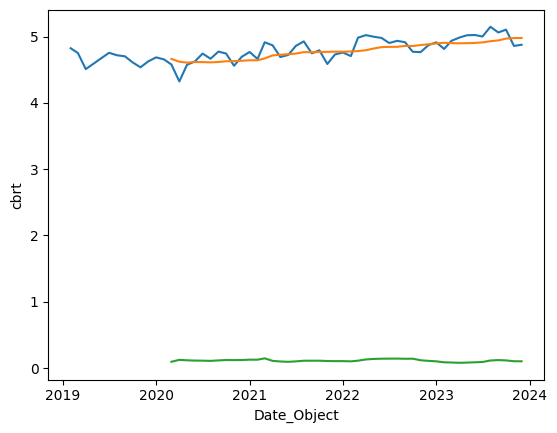

In [25]:
test_stationarity(cbrt_df,'cbrt')

We got better results in log, sqrt, and cbrt, compared to time shifting. We can combine log and sqrt for a mix variant model.

In [26]:
log_df2 = log_df[['Total_Power_Generation','log']]
log_df2['log_sqrt'] = np.sqrt(log_df['log'])
log_df2['log_shiftdiff'] = log_df2['log_sqrt'] - log_df2['log_sqrt'].shift()
log_df2.head()

C:\Users\adity\AppData\Local\Temp\ipykernel_13944\457026870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df2['log_sqrt'] = np.sqrt(log_df['log'])


,Total_Power_Generation,log,log_sqrt,log_shiftdiff
Date_Object,,,,
2019-02-01,112.22261,4.720484,2.172668,NaN
2019-03-01,107.36345,4.676220,2.162457,-0.010211
2019-04-01,91.67904,4.518294,2.125628,-0.036829
2019-07-01,107.53155,4.677784,2.162819,0.037191
2019-08-01,105.01283,4.654083,2.157332,-0.005486


We will find difference of log and log_sqrt and time shifting and perform test stationarity

C:\Users\adity\AppData\Local\Temp\ipykernel_13944\2896759308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollmean'] = dataFrame[var].rolling(window=12).mean()
C:\Users\adity\AppData\Local\Temp\ipykernel_13944\2896759308.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollstd'] = dataFrame[var].rolling(window=12).std()


Test Statistic                 -2.803266
p-value                         0.057809
#lags used                      0.000000
number of observations used    55.000000
dtype: float64
criticality 1% :  -3.5552728880540942
criticality 5% :  -2.9157312396694217
criticality 10% :  -2.5956695041322315


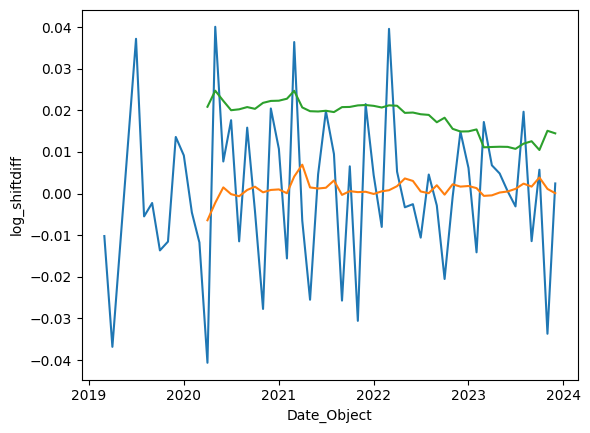

In [27]:
test_stationarity(log_df2.dropna(),'log_shiftdiff')

This curve is very much acceptable.

We will build ARIMA model with original data first, as building with the stationery data is somewhat complex.

In [28]:
airP = df[['Total_Power_Generation']].copy(deep=True)       #we wont modify original data.

In [29]:
airP.head()

,Total_Power_Generation
Date_Object,
2019-02-01,112.22261
2019-03-01,107.36345
2019-04-01,91.67904
2019-07-01,107.53155
2019-08-01,105.01283


Seasonlity is on 12 months, so we will shift by 12 months.

In [30]:
airP['FirstDiff'] = airP['Total_Power_Generation'].diff()
airP['Diff12'] = airP['Total_Power_Generation'].diff(12)

In [31]:
airP.head()

,Total_Power_Generation,FirstDiff,Diff12
Date_Object,,,
2019-02-01,112.22261,NaN,NaN
2019-03-01,107.36345,-4.85916,NaN
2019-04-01,91.67904,-15.68441,NaN
2019-07-01,107.53155,15.85251,NaN
2019-08-01,105.01283,-2.51872,NaN


In [32]:
#importing ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

AR - AutoRegressive : p

I - Integration : d

MA - Moving Averages : q

We have to supply p,d,q

1. d is the number of shiftings we are done, eg 1 month shift, d = 1, or 12 months shift, d = 12

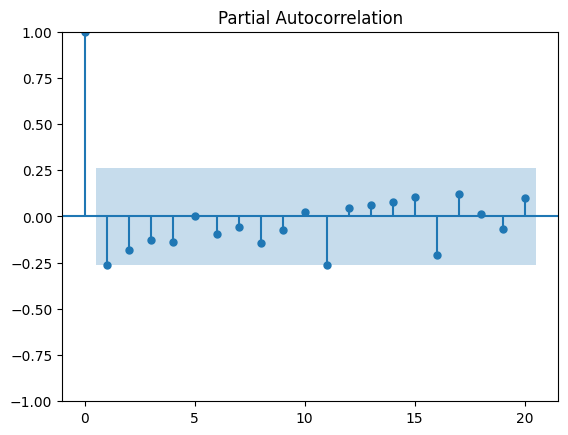

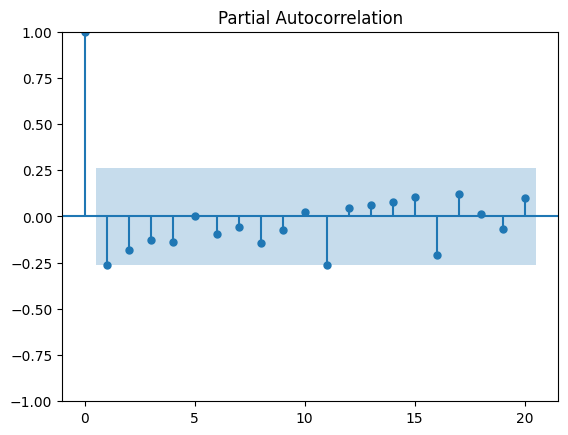

In [33]:
plot_pacf(airP['FirstDiff'].dropna(),lags=20)

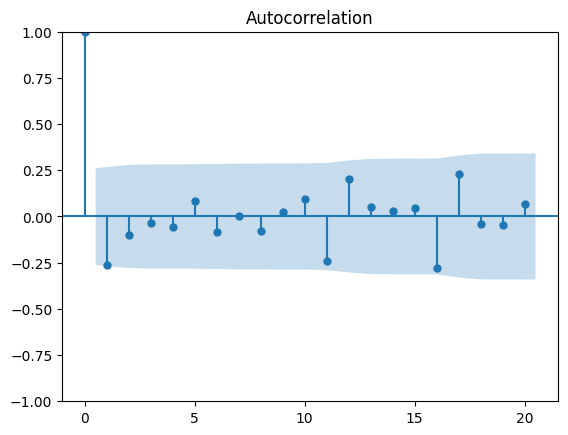

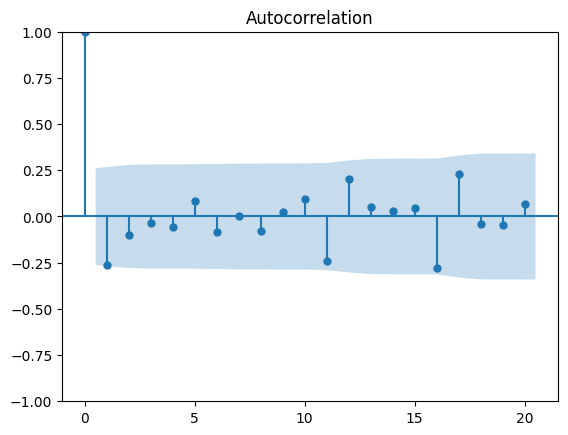

In [34]:
plot_acf(airP['FirstDiff'].dropna(),lags=20)

In [35]:
from pmdarima.arima import auto_arima

In [36]:
stepwise_fit = auto_arima(airP['FirstDiff'].dropna(), trace = True, suppress_warnings=True)
stepwise_fit.summary()
#this gives different combinations of p, q, and q. depending on least AIC value

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=400.017, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=398.107, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=395.523, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=398.021, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=393.646, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=392.204, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=396.115, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=394.188, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=394.188, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=392.636, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=395.837, Time=0.03 se

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -193.102
Date:                Tue, 12 Mar 2024   AIC                            392.204
Time:                        14:58:35   BIC                            398.280
Sample:                             0   HQIC                           394.560
                                 - 56                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4223      0.252      1.679      0.093      -0.071       0.915
ma.L1         -0.8333      0.144     -5.800      0.000      -1.115      -0.552
sigma2        57.3651     10.931      5.248      0.000      35.941      78.789
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.69
Prob(Q):                              0.97   Prob(JB):                         0.71
Heteroskedasticity (H):               0.70   Skew:                            -0.27
Prob(H) (two-sided):                  0.45   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Shaded area is insignificant area and outside that is significant area.

In [37]:
#p = 1, q = 1, d = 1

We will make training data now.70% training data 30% testing data

In [38]:
round(len(airP)*70/100)

40

In [39]:
train = airP[:round(len(airP)*70/100)]
train.tail()

,Total_Power_Generation,FirstDiff,Diff12
Date_Object,,,
2022-03-01,123.75158,19.57527,5.11041
2022-04-01,126.64498,2.89340,11.31828
2022-05-01,124.82180,-1.82318,21.56285
2022-06-01,123.43167,-1.39013,18.09347
2022-07-01,117.83792,-5.59375,3.05276


In [40]:
test = airP[round(len(airP)*70/100):]
test.head()

,Total_Power_Generation,FirstDiff,Diff12
Date_Object,,,
2022-08-01,120.22088,2.38296,0.57912
2022-09-01,118.72502,-1.49586,11.74376
2022-10-01,108.58351,-10.14151,-1.47419
2022-11-01,108.21292,-0.37059,11.73569
2022-12-01,115.43459,7.22167,9.62158


FirstDiff and Diff12 are only used to analyse the mean and variance only.

In [41]:
import statsmodels.api


In [42]:
model = statsmodels.tsa.arima.model.ARIMA(train['Total_Power_Generation'],order=(1,0,1))
model_fit = model.fit()
prediction = model_fit.predict(start=test.shape[0], end=(train.shape[0]+test.shape[0]-1),dynamic=False)

c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is ava

In [43]:
prediction

17    103.941070
18    107.478929
19    106.977839
20    100.452875
21    104.069475
22    107.289710
23    104.018225
24    112.804387
25    112.438142
26    105.890291
27    105.953076
28    111.042824
29    114.474462
30    108.219942
31    108.866189
32    101.668118
33    105.527952
34    107.243132
35    105.546347
36    115.798520
37    119.006503
38    118.543166
39    117.721024
40    114.580771
41    112.323331
42    110.745705
43    109.643172
44    108.872659
45    108.334182
46    107.957863
47    107.694871
48    107.511077
49    107.382632
50    107.292867
51    107.230134
52    107.186293
53    107.155654
54    107.134242
55    107.119278
56    107.108820
Name: predicted_mean, dtype: float64

In [44]:
assert len(prediction) == 40
airP['arimaPred'] = float('NaN')
airP.iloc[17:57, airP.columns.get_loc('arimaPred')] = prediction

In [45]:
airP

,Total_Power_Generation,FirstDiff,Diff12,arimaPred
Date_Object,,,,
2019-02-01,112.22261,NaN,NaN,NaN
2019-03-01,107.36345,-4.85916,NaN,NaN
2019-04-01,91.67904,-15.68441,NaN,NaN
2019-07-01,107.53155,15.85251,NaN,NaN
2019-08-01,105.01283,-2.51872,NaN,NaN
2019-09-01,103.99120,-1.02163,NaN,NaN
2019-10-01,98.06368,-5.92752,NaN,NaN
2019-11-01,93.34629,-4.71739,NaN,NaN
2019-12-01,98.93263,5.58634,NaN,NaN


In [46]:
train

,Total_Power_Generation,FirstDiff,Diff12
Date_Object,,,
2019-02-01,112.22261,NaN,NaN
2019-03-01,107.36345,-4.85916,NaN
2019-04-01,91.67904,-15.68441,NaN
2019-07-01,107.53155,15.85251,NaN
2019-08-01,105.01283,-2.51872,NaN
2019-09-01,103.99120,-1.02163,NaN
2019-10-01,98.06368,-5.92752,NaN
2019-11-01,93.34629,-4.71739,NaN
2019-12-01,98.93263,5.58634,NaN


In [47]:
train['arimaPred'] = airP['arimaPred'].copy()
test['arimaPred'] = airP['arimaPred'].copy()


C:\Users\adity\AppData\Local\Temp\ipykernel_13944\3906530292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['arimaPred'] = airP['arimaPred'].copy()
C:\Users\adity\AppData\Local\Temp\ipykernel_13944\3906530292.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['arimaPred'] = airP['arimaPred'].copy()


<Axes: xlabel='Date_Object', ylabel='Total_Power_Generation'>

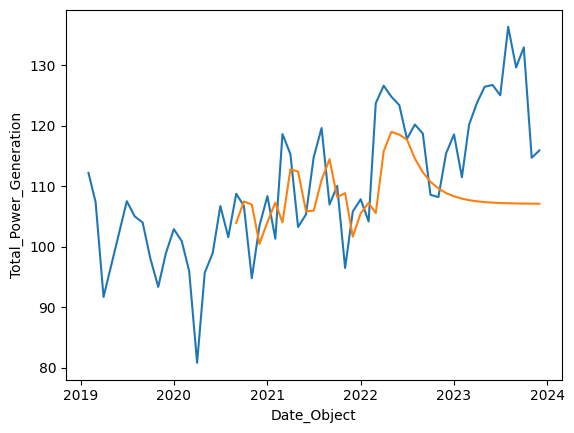

In [48]:
airP.dropna()
sns.lineplot(data=airP,x=airP.index,y='Total_Power_Generation')
sns.lineplot(data=airP,x=airP.index,y='arimaPred')

There is somewhat error here, we will look in Seasonal ARIMA model

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

In [50]:
airP.head()

,Total_Power_Generation,FirstDiff,Diff12,arimaPred
Date_Object,,,,
2019-02-01,112.22261,NaN,NaN,NaN
2019-03-01,107.36345,-4.85916,NaN,NaN
2019-04-01,91.67904,-15.68441,NaN,NaN
2019-07-01,107.53155,15.85251,NaN,NaN
2019-08-01,105.01283,-2.51872,NaN,NaN


We are gonna use the Diff12 values

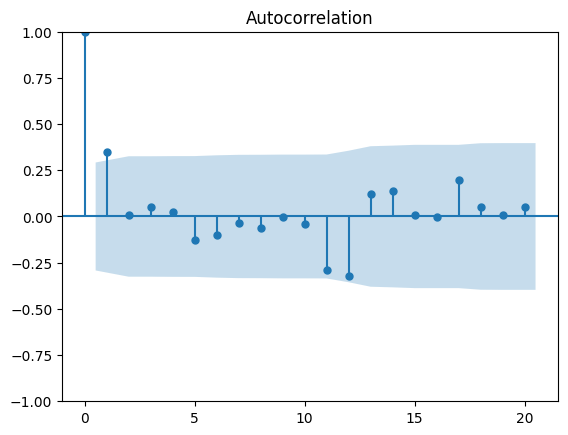

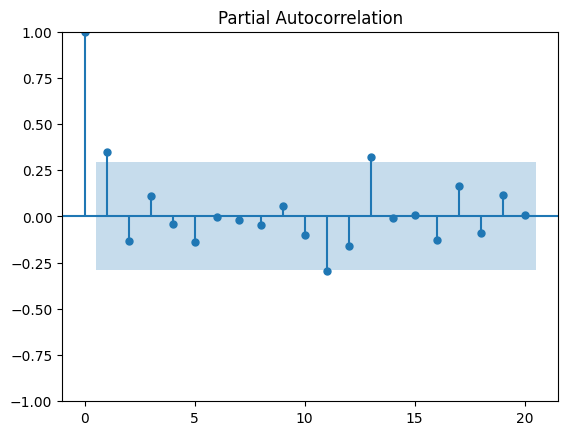

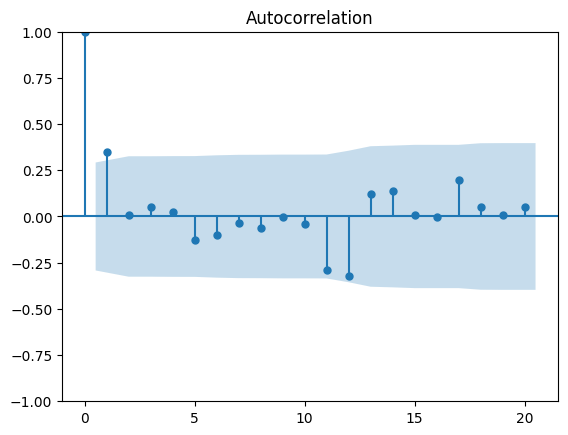

In [51]:
plot_pacf(airP['Diff12'].dropna(),lags = 20)
plot_acf(airP['Diff12'].dropna(),lags = 20)

In [52]:
model = sm.tsa.statespace.SARIMAX(train['Total_Power_Generation'],order=(1,1,1),seasonal_order=(2,1,2,12))
model_fit = model.fit()
prediction1 = model_fit.predict(start=test.shape[0], end=(train.shape[0]+test.shape[0]-1),dynamic=False)
prediction1

c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


17     97.103581
18     96.952674
19     95.561715
20     97.663811
21    104.438733
22    104.553244
23     99.094786
24    101.862384
25    113.282990
26     97.082804
27    114.018564
28    109.072817
29    117.709725
30    104.777848
31    100.509274
32    104.846348
33    110.812499
34    105.433689
35    113.345592
36    114.153603
37    119.300777
38    115.066019
39    128.876203
40    118.239467
41    116.726166
42    115.166613
43    105.714993
44    113.541504
45    117.328562
46    113.518418
47    123.276369
48    118.045807
49    119.101106
50    118.657494
51    124.178205
52    123.467717
53    122.139102
54    121.166234
55    110.261507
56    118.548032
Name: predicted_mean, dtype: float64

In [53]:
assert len(prediction1) == 40
airP['sarimaPred'] = float('NaN')
airP.iloc[17:57, airP.columns.get_loc('sarimaPred')] = prediction1

In [54]:
airP

,Total_Power_Generation,FirstDiff,Diff12,arimaPred,sarimaPred
Date_Object,,,,,
2019-02-01,112.22261,NaN,NaN,NaN,NaN
2019-03-01,107.36345,-4.85916,NaN,NaN,NaN
2019-04-01,91.67904,-15.68441,NaN,NaN,NaN
2019-07-01,107.53155,15.85251,NaN,NaN,NaN
2019-08-01,105.01283,-2.51872,NaN,NaN,NaN
2019-09-01,103.99120,-1.02163,NaN,NaN,NaN
2019-10-01,98.06368,-5.92752,NaN,NaN,NaN
2019-11-01,93.34629,-4.71739,NaN,NaN,NaN
2019-12-01,98.93263,5.58634,NaN,NaN,NaN


<Axes: xlabel='Date_Object', ylabel='Total_Power_Generation'>

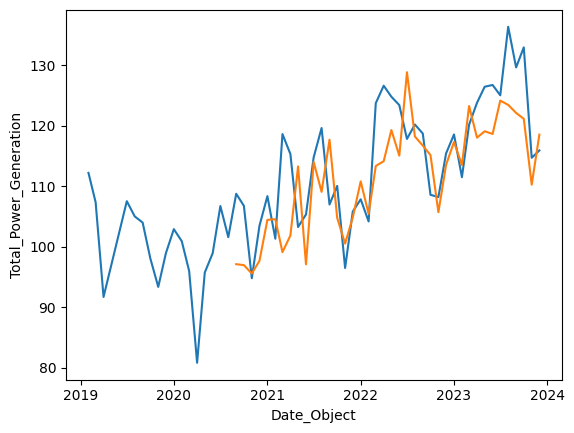

In [55]:
sns.lineplot(data=airP,x=airP.index,y='Total_Power_Generation')
sns.lineplot(data=airP,x=airP.index,y='sarimaPred')

<Axes: xlabel='Date_Object', ylabel='Total_Power_Generation'>

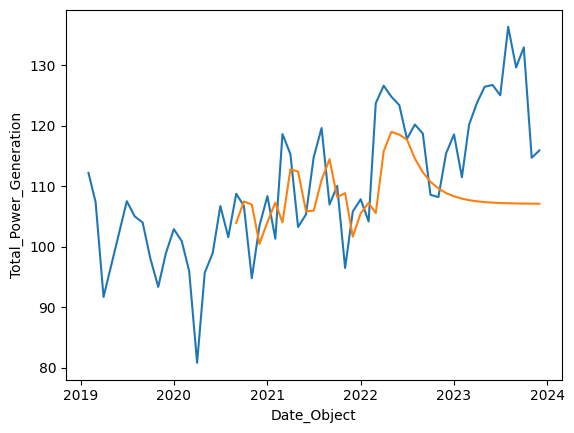

In [56]:
sns.lineplot(data=airP,x=airP.index,y='Total_Power_Generation')
sns.lineplot(data=airP,x=airP.index,y='arimaPred')

FUTURE PREDICTION

In [57]:
airP.tail()

,Total_Power_Generation,FirstDiff,Diff12,arimaPred,sarimaPred
Date_Object,,,,,
2023-08-01,136.39555,11.34113,16.17467,107.186293,123.467717
2023-09-01,129.66907,-6.72648,10.94405,107.155654,122.139102
2023-10-01,132.99263,3.32356,24.40912,107.134242,121.166234
2023-11-01,114.71275,-18.27988,6.49983,107.119278,110.261507
2023-12-01,115.93517,1.22242,0.50058,107.108820,118.548032


We will generate dates for future

In [58]:
future_Date = pd.DataFrame(pd.date_range(start='2024-01-01', end='2030-12-01',freq='MS'),columns=['Dates'])
future_Date.set_index('Dates',inplace=True)
future_Date.head()

""
Dates
2024-01-01
2024-02-01
2024-03-01
2024-04-01
2024-05-01


In [59]:
forecast = model_fit.predict(start=future_Date.shape[0],end=(future_Date.shape[0]+future_Date.shape[0]-1),dynamic=False)


c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [60]:
len(future_Date)

84

In [61]:
assert len(forecast) == 84
future_Date['Forecast'] = float('NaN')
future_Date.iloc[0:84, future_Date.columns.get_loc('Forecast')] = forecast

In [62]:
future_Date.head()
print(future_Date.index)

DatetimeIndex(['2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01',
               '2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01',
               '2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01',
               '2025-09-01', '2025-10-01', '2025-11-01', '2025-12-01',
               '2026-01-01', '2026-02-01', '2026-03-01', '2026-04-01',
               '2026-05-01', '2026-06-01', '2026-07-01', '2026-08-01',
               '2026-09-01', '2026-10-01', '2026-11-01', '2026-12-01',
               '2027-01-01', '2027-02-01', '2027-03-01', '2027-04-01',
               '2027-05-01', '2027-06-01', '2027-07-01', '2027-08-01',
               '2027-09-01', '2027-10-01', '2027-11-01', '2027-12-01',
               '2028-01-01', '2028-02-01', '2028-03-01', '2028-04-01',
               '2028-05-01', '2028-06-01', '2028-07-01', '2028-08-01',
      

<Axes: xlabel='Dates', ylabel='Forecast'>

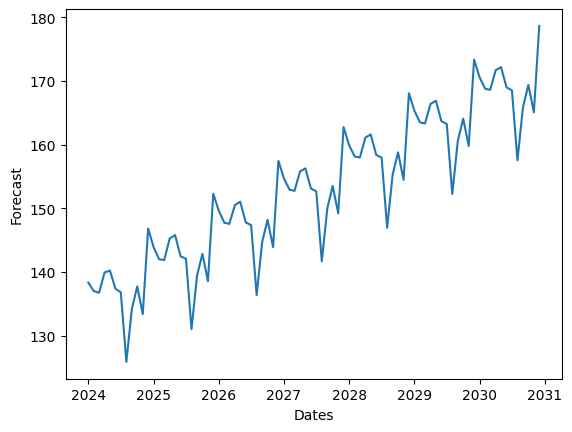

In [65]:
sns.lineplot(data=future_Date,x=future_Date.index,y='Forecast')

<Axes: xlabel='Date_Object', ylabel='Total_Power_Generation'>

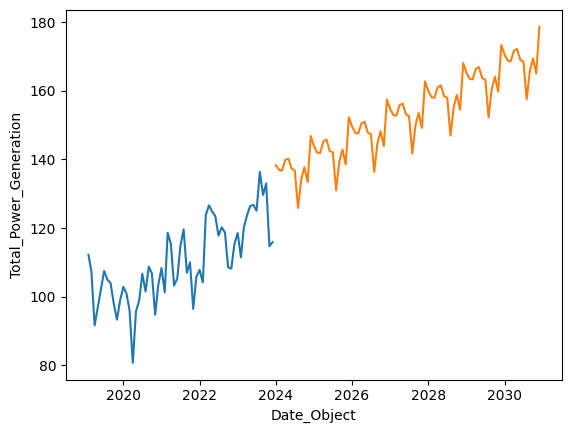

In [63]:
sns.lineplot(data=airP,x=airP.index,y='Total_Power_Generation')
sns.lineplot(data=future_Date,x=future_Date.index,y='Forecast')

The graph is somewhat discontinous, so we make it continous

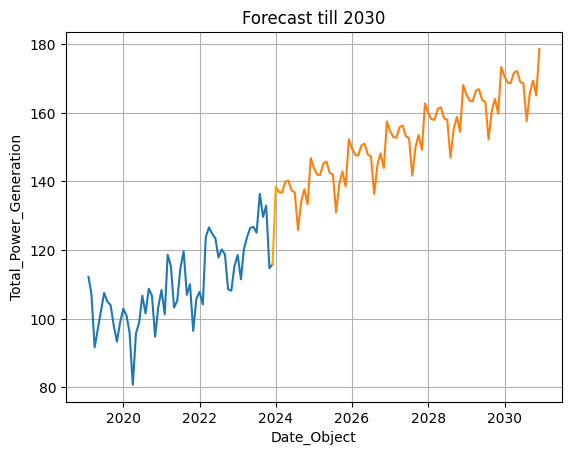

In [64]:
last_total_power_generation = airP['Total_Power_Generation'].iloc[-1]
first_forecast = future_Date['Forecast'].iloc[0]
sns.lineplot(data=airP,x=airP.index,y='Total_Power_Generation')
sns.lineplot(data=future_Date,x=future_Date.index,y='Forecast')
plt.plot([airP.index[-1], future_Date.index[0]], [last_total_power_generation, first_forecast], color='orange')
plt.title('Forecast till 2030')
plt.grid()
